# Forecasting Sales

In [51]:
# Standard Packages
import pandas as pd
import numpy as np
import warnings
import re
import time

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler, MinMaxScaler
# from sklearn.impute import SimpleImputer

## SKLearn Random Forest
from sklearn.ensemble import RandomForestRegressor

## SKLearn Pipeline and Transformer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## SKLearn Metrics
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

# ## Statsmodel Time Series modules
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.api import SARIMAX, AutoReg
# from statsmodels.tsa.stattools import adfuller

## Holidays package
from datetime import date
import holidays

In [52]:
# Notebook Config
## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = None
pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

## Business Problem and Data

- Covid has highlighted the importance of sales forecasting/demand planning capabilities for manufacturers, wholesalers, and retailers
  - Ex: Peloton Covid demand surge CapEx
  
- Without sales forecasting/demand planning tools, Walmart’s marketplace sellers are unable to optimally plan their business activity  
  - However implementation of ERPs/CRMs is too resource intensive for many (smaller) Marketplace sellers

- Our team, Walmart Store Sales DS, has been approached by members of the Marketplace Strategy and Product teams

- Can we leverage our expertise to develop an affordable forecasting/planning solution for Walmart Marketplace sellers

- Historical Walmart store sales data
  - 2.75 yrs (2010-02-05 to 2012-10-26)
  
- Data was provided by colleagues from finance  
  - Certain historical data was deleted prior to handoff to simulate the less than ideal data we expect our sellers to have at their disposal
  
- Target variable is Weekly Sales

- Features include various internal and external factors
  - Internal ex: store type, size, markdown levels, promotional periods
  - External ex: CPI, temperature, gas prices


## Read in and Inspect the provided datasets

In [53]:
# Load the provided datasets
stores_df = pd.read_csv('data/stores.csv')
features_df = pd.read_csv('data/features.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

In [54]:
# inspect stores df
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [55]:
stores_df.info() # no missing values, convert type to nominal or ordinal?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [56]:
stores_df['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [57]:
# Inspect the features data
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [58]:
features_df.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [59]:
features_df.info() # Missing markdown values as expected, some nulls for CPI and unemployment as well
# Need to convert 'Date' to datetime and 'IsHoliday' to numerical bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [60]:
# Drill down further on nulls
features_df.isna().sum() # some to keep an eye, but expect some to resolve upon merging our datasets

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [62]:
# Inspect the provided datasets
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [63]:
train_df.info() # Has the most values - merge stores and features onto this dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [64]:
# Inspect the test data
test_df.head() # will need to also merge the stores and features datasets to our test set?

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [66]:
test_df.info() # roughly 80/20 train/test split
# actually won't be using this as we don't have the actual sales forecast values from the offical test set
# will have to take a subset of the training data to make a validation set 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [67]:
# Combine datasets
train_df = train_df.merge(features_df, how='left').merge(stores_df, how='left')
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [68]:
# Reorder columns to group similar features 
cols = list(train_df.columns.values)
cols # move 'Type' and 'Size' to after 'Dept', 'CPI' and 'Unemployment' after 'Fuel_Price'

['Store',
 'Dept',
 'Date',
 'Weekly_Sales',
 'IsHoliday',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Type',
 'Size']

In [69]:
# rewrite df with new column ordering
train_df = train_df[['Store','Dept','Type','Size','Date','Weekly_Sales','IsHoliday','Temperature',
                         'Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                         'MarkDown5']]

In [70]:
# Combine datasets for testing set to mirror training set
test_df = test_df.merge(features_df, how='left').merge(stores_df, how='left')
test_df

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221
115060,45,98,2013-07-05,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221


In [71]:
# add column to hold predicted weekly sales values 
test_df['Weekly_Sales'] = ''

In [72]:
# reorder columns to mirror transformation to training df
test_df = test_df[['Store','Dept','Type','Size','Date','Weekly_Sales','IsHoliday','Temperature',
                         'Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                         'MarkDown5']]

In [73]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Type          115064 non-null  object 
 3   Size          115064 non-null  int64  
 4   Date          115064 non-null  object 
 5   Weekly_Sales  115064 non-null  object 
 6   IsHoliday     115064 non-null  bool   
 7   Temperature   115064 non-null  float64
 8   Fuel_Price    115064 non-null  float64
 9   CPI           76902 non-null   float64
 10  Unemployment  76902 non-null   float64
 11  MarkDown1     114915 non-null  float64
 12  MarkDown2     86437 non-null   float64
 13  MarkDown3     105235 non-null  float64
 14  MarkDown4     102176 non-null  float64
 15  MarkDown5     115064 non-null  float64
dtypes: bool(1), float64(9), int64(3), object(3)
memory usage: 14.2+ MB


## EDA

In [74]:
# check for nulls and dytpes again
train_df.info() # no nulls in CPI and Unemployment now, will need to see what's going there

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Type          421570 non-null  object 
 3   Size          421570 non-null  int64  
 4   Date          421570 non-null  object 
 5   Weekly_Sales  421570 non-null  float64
 6   IsHoliday     421570 non-null  bool   
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  MarkDown1     150681 non-null  float64
 12  MarkDown2     111248 non-null  float64
 13  MarkDown3     137091 non-null  float64
 14  MarkDown4     134967 non-null  float64
 15  MarkDown5     151432 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


<AxesSubplot: >

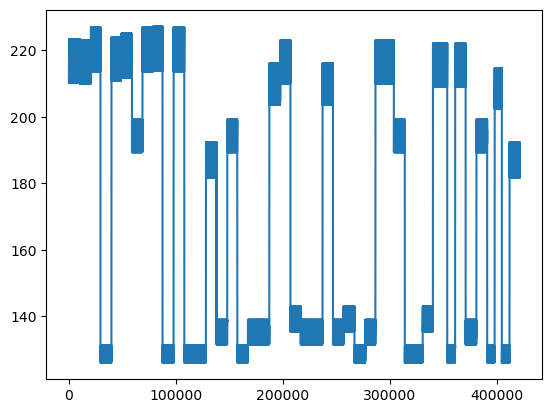

In [75]:
train_df['CPI'].plot()

<AxesSubplot: >

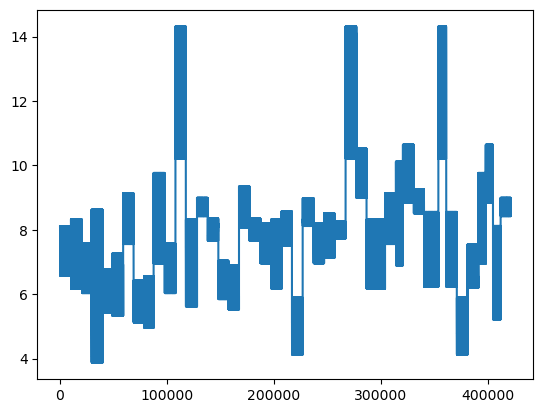

In [76]:
train_df['Unemployment'].plot()

In [77]:
train_df.isna().sum() # no more missing values - different reporting windows

Store                0
Dept                 0
Type                 0
Size                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
dtype: int64

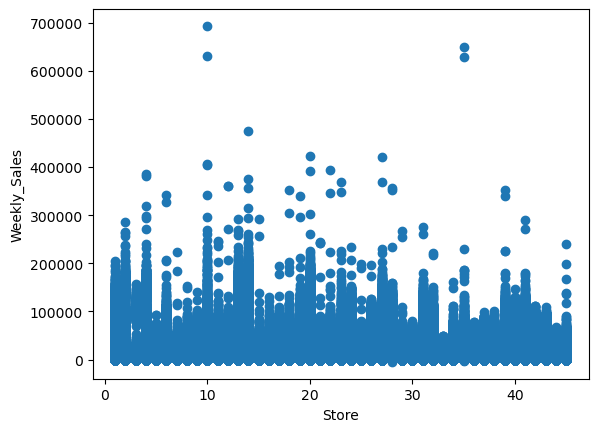

<Figure size 600x400 with 0 Axes>

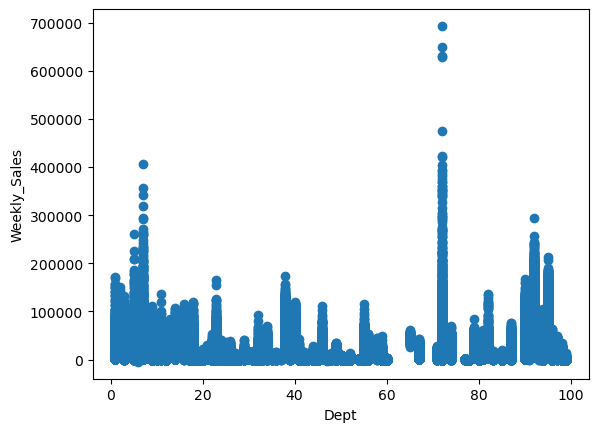

<Figure size 600x400 with 0 Axes>

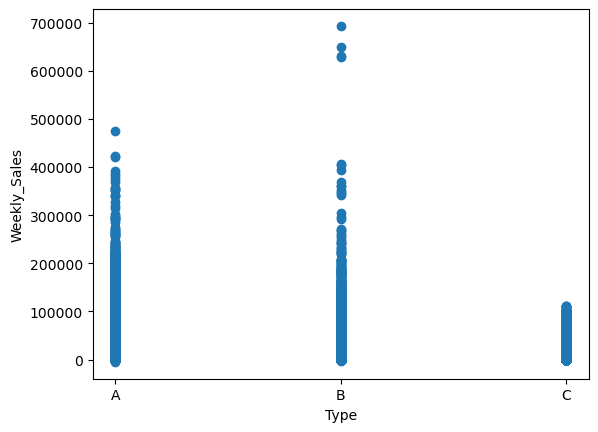

<Figure size 600x400 with 0 Axes>

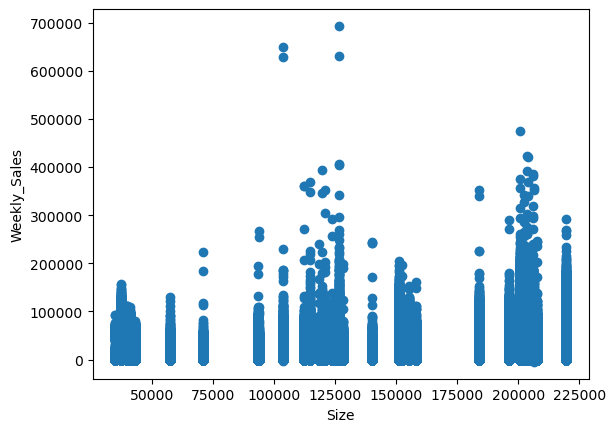

<Figure size 600x400 with 0 Axes>

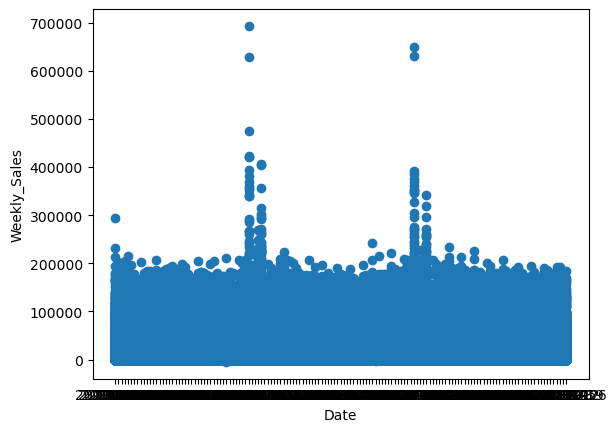

<Figure size 600x400 with 0 Axes>

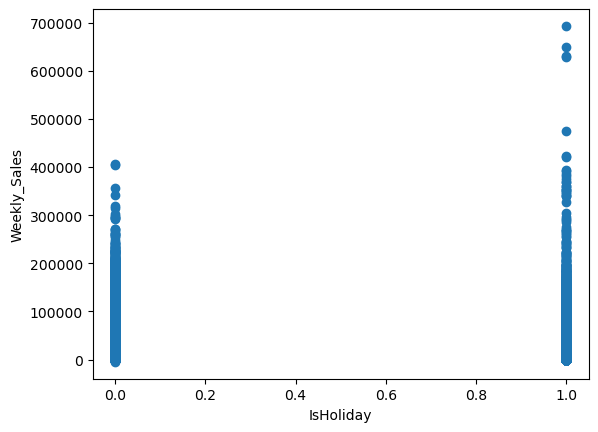

<Figure size 600x400 with 0 Axes>

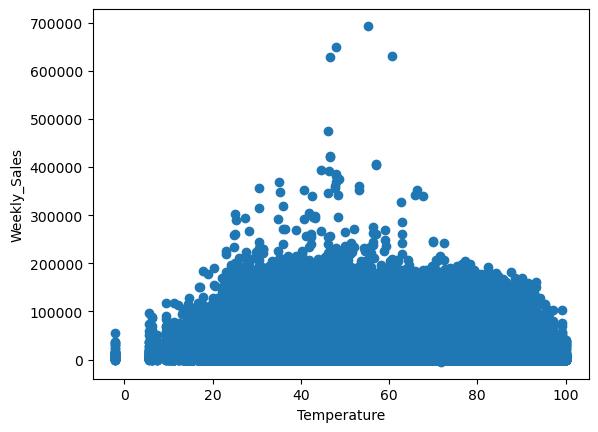

<Figure size 600x400 with 0 Axes>

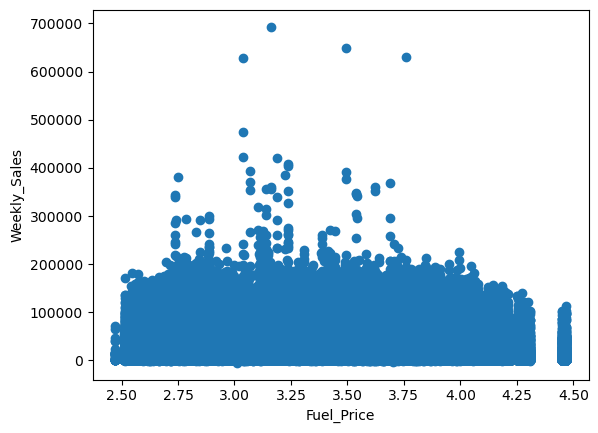

<Figure size 600x400 with 0 Axes>

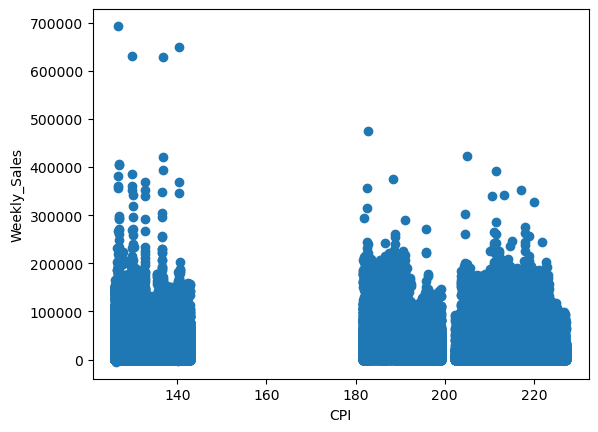

<Figure size 600x400 with 0 Axes>

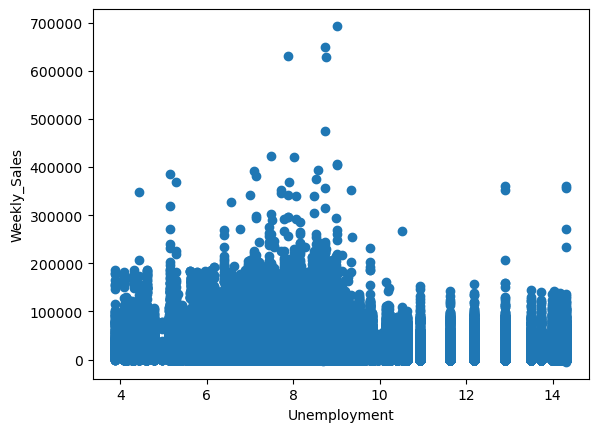

<Figure size 600x400 with 0 Axes>

In [78]:
# Visualize feature distributions excl markdown and sales cols with scatter plots
cols_to_scatter = ['Store','Dept','Type','Size','Date','IsHoliday','Temperature',
                   'Fuel_Price','CPI','Unemployment']
for col in cols_to_scatter:
    plt.figure()
    plt.scatter(train_df[col], train_df['Weekly_Sales'])
    plt.xlabel(col)
    plt.ylabel('Weekly_Sales')
    plt.figure(figsize=(6,4))

While some type 'B' and midsize stores have sales numbers bigger than some type 'A' and larger stores, we'll handle type ordinally
- big drop off when store type is 'C'

Two huge sales bumps in the date plot
- guessing its thanksgiving/black friday and christmas, but we'll want to drill down on that later 


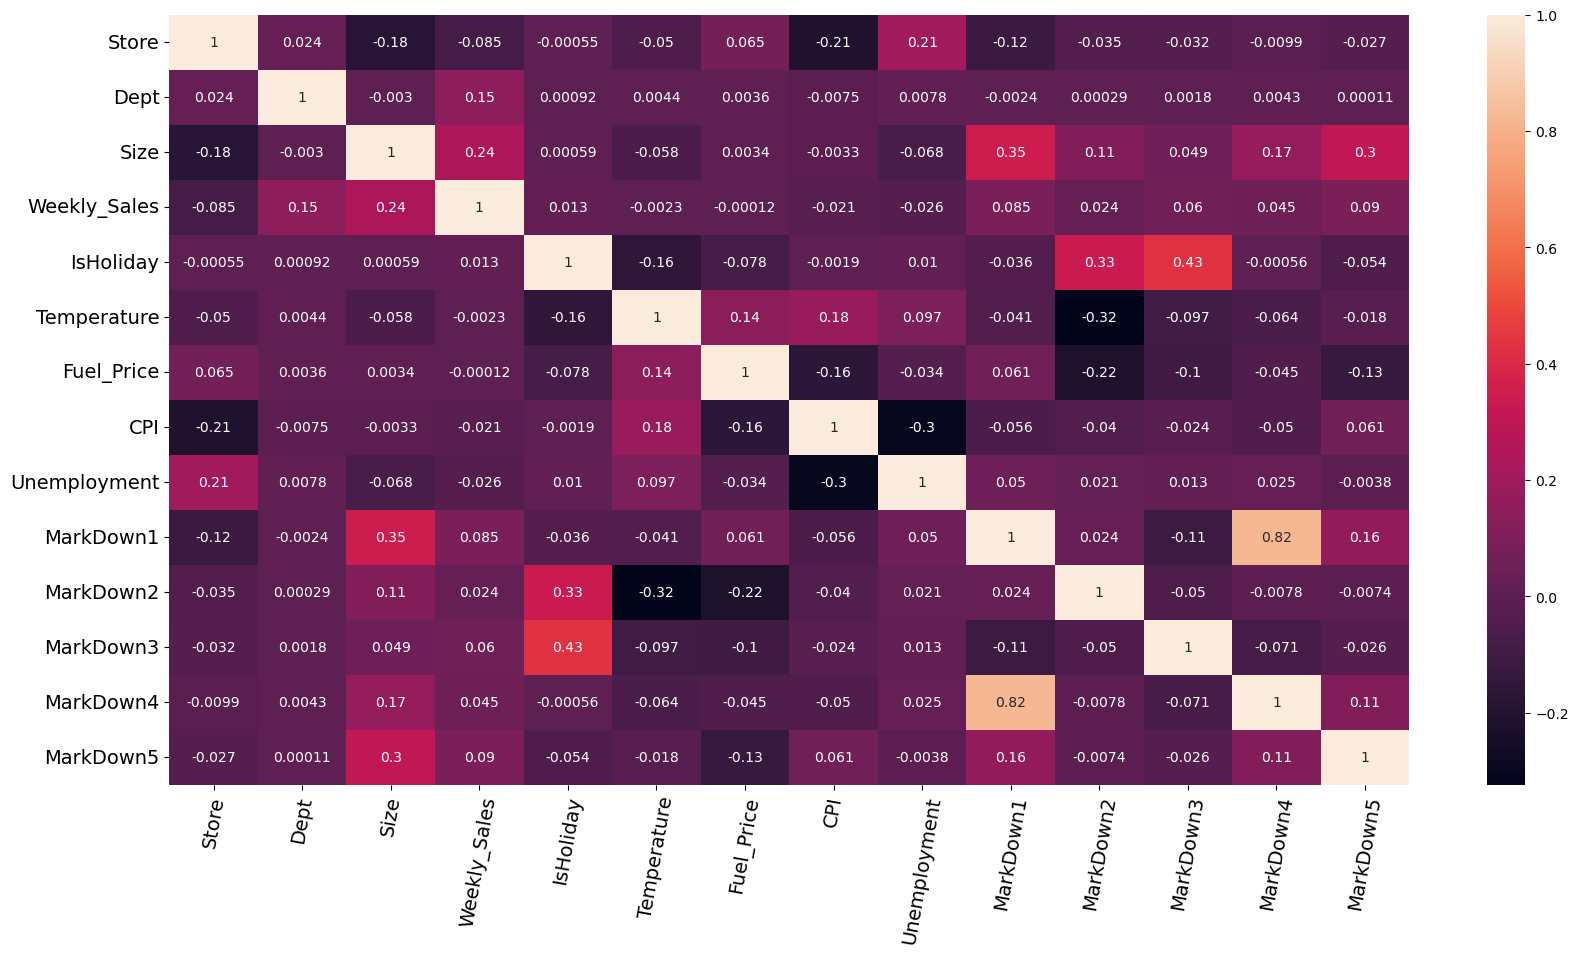

In [79]:
# Check correlation of numerical features
plt.figure(figsize=(20,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True)
plt.xticks(rotation=80, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

- nothing really jumps out as being highly correlated
- unexpectedly low correlation for many features such as markdowns and external factors such as CPI, gas prices, and the unemployment rate
- could be a case where the best predictor of future values is truly past values

In [80]:
# Extract years, months, weeks from the date and weekly sales into new cols for testing and training dfs
# allows us to group sales by diffrent windows and plot so we can look for trends
# Also necessary for running models later on
# Convert date col to datetime object for training and test sets
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract Years, Months, and Weeks from date col in both sets
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.week

test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Week'] = test_df['Date'].dt.week

In [81]:
# Aggregate average sales by year by week to indentify trends in weekly sales 
weekly_2010 = train_df.loc[train_df['Year'] == 2010].groupby('Week')['Weekly_Sales'].mean()
weekly_2011 = train_df.loc[train_df['Year'] == 2011].groupby('Week')['Weekly_Sales'].mean()
weekly_2012 = train_df.loc[train_df['Year'] == 2012].groupby('Week')['Weekly_Sales'].mean()

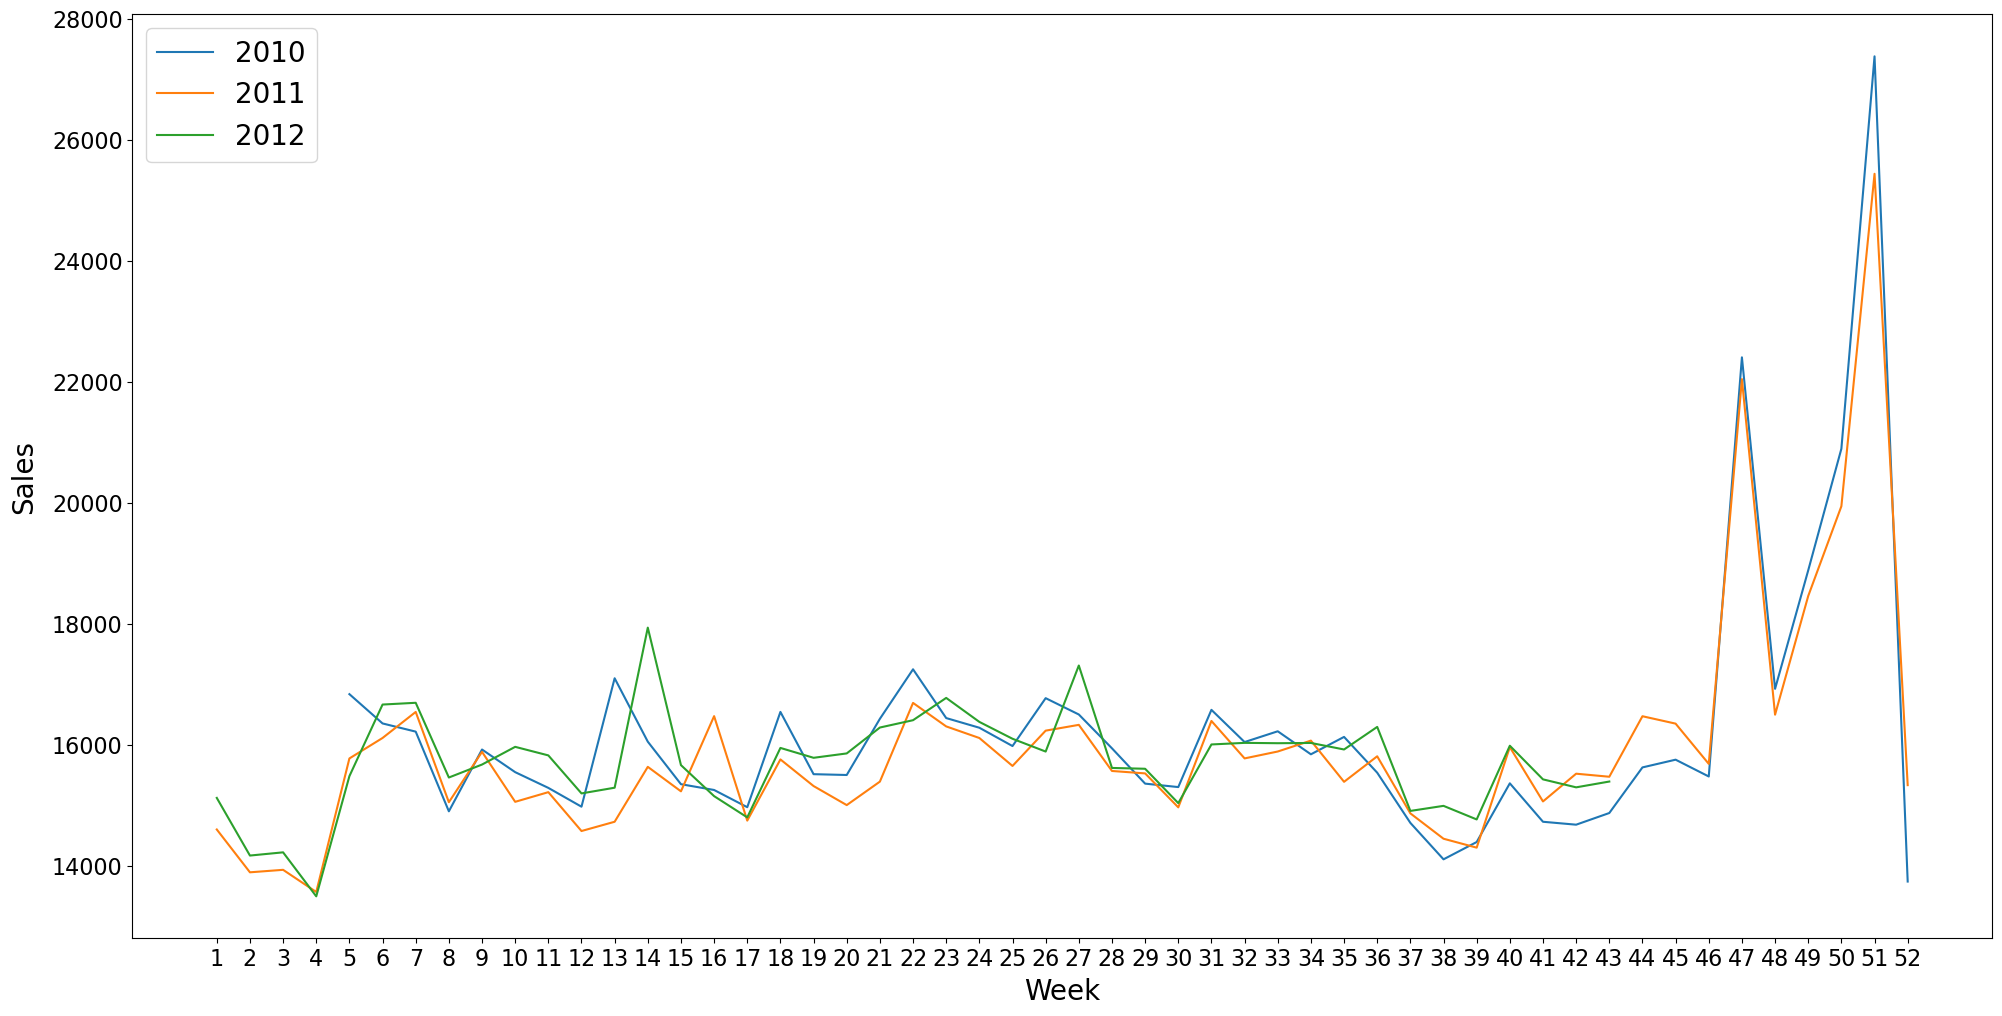

In [113]:
# Plot the groupby dfs created above
# One chart overlaid with a line plot for each year
fig, ax = plt.subplots(figsize=(24,12))

ax1 = plt.plot(weekly_2010.index, weekly_2010.values)
ax2 = plt.plot(weekly_2011.index, weekly_2011.values)
ax3 = plt.plot(weekly_2012.index, weekly_2012.values)

plt.ylabel('Sales', fontsize=20, labelpad=10)
plt.xlabel('Week', fontsize=20, labelpad=5)
plt.yticks(fontsize=16)
plt.xticks(np.arange(1,53,step=1), fontsize=16)

plt.legend(['2010', '2011', '2012'], fontsize=20)


- bumps at weeks 5-6 is explaine by the supwerbowl
- bumps at weeks 13-14 could be explained by easter
- bumps at weeks 22-23 could be explained by memorial day
- bumps at weeks 26-27 could be explained by the fourth of july
- Big bump between weeks 46-48 for thanksgiving and black friday
- Big bump between weeks 50-51 for xmas and NYE

### Handle Categorical Variables

In [83]:
# Encode type as ordinal values
train_df['Type'] = train_df['Type'].map({'A':'1', 'B':'2', 'C':'3'})
test_df['Type'] = test_df['Type'].map({'A':'1', 'B':'2', 'C':'3'})

In [84]:
# Confirm successful mapping in training set
train_df.info() # success, but need to convert type and isholiday to int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Type          421570 non-null  object        
 3   Size          421570 non-null  int64         
 4   Date          421570 non-null  datetime64[ns]
 5   Weekly_Sales  421570 non-null  float64       
 6   IsHoliday     421570 non-null  bool          
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  MarkDown1     150681 non-null  float64       
 12  MarkDown2     111248 non-null  float64       
 13  MarkDown3     137091 non-null  float64       
 14  MarkDown4     134967 non-null  float64       
 15  MarkDown5     151

In [85]:
# Confirm successful mapping in testing set
test_df.info() # success, but need to convert type and isholiday to int

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Type          115064 non-null  object        
 3   Size          115064 non-null  int64         
 4   Date          115064 non-null  datetime64[ns]
 5   Weekly_Sales  115064 non-null  object        
 6   IsHoliday     115064 non-null  bool          
 7   Temperature   115064 non-null  float64       
 8   Fuel_Price    115064 non-null  float64       
 9   CPI           76902 non-null   float64       
 10  Unemployment  76902 non-null   float64       
 11  MarkDown1     114915 non-null  float64       
 12  MarkDown2     86437 non-null   float64       
 13  MarkDown3     105235 non-null  float64       
 14  MarkDown4     102176 non-null  float64       
 15  MarkDown5     115

In [86]:
# convert type and is holiday to into
train_df['Type'] = train_df['Type'].astype(int)
test_df['Type'] = test_df['Type'].astype(int)

train_df['IsHoliday'] = train_df['IsHoliday'].astype(int)
test_df['IsHoliday'] = test_df['IsHoliday'].astype(int)

In [87]:
# Need ot check for any outstanding NaNs as the regressor used for modeling cannot handle them
print(train_df.isna().sum())
print(test_df.isna().sum())

Store                0
Dept                 0
Type                 0
Size                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
Year                 0
Month                0
Week                 0
dtype: int64
Store               0
Dept                0
Type                0
Size                0
Date                0
Weekly_Sales        0
IsHoliday           0
Temperature         0
Fuel_Price          0
CPI             38162
Unemployment    38162
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
Year                0
Month               0
Week                0
dtype: int64


In [88]:
# Fill NaNs with 0s so model will run
train_df.fillna(value=0, inplace=True)
test_df.fillna(value=0, inplace=True)

## Modeling

### Baseline Model

Run Random Forest using all available features

In [96]:
# Assign features to X and target to y
# Drop the date column as date values have been extracted in individual columns
X_all = train_df.drop(['Date', 'Weekly_Sales'], axis =1)
val_df = train_df[['Weekly_Sales']]
val_df.index = train_df.Year

# Split train df into X and val based on year
X_train_all = X_all.loc[(X_all['Year'] == 2010) | (X_all['Year'] == 2011)]
X_test_all = X_all.loc[(X_all['Year'] == 2012)]
y_train_all = val_df.loc[(val_df.index == 2010) | (val_df.index == 2011)]
y_test_all = val_df.loc[(val_df.index == 2012)]

In [97]:
X_train_all.shape

(294132, 17)

In [98]:
train_df.isnull().values.any()

False

In [99]:
# Instantiate random forest regressor
rfr = RandomForestRegressor(max_depth=20, random_state=42)
rfr.fit(X_train_all, y_train_all)

train_all_preds = rfr.predict(X_test_all)

In [100]:
# Define score variables
rmse_all = MSE(y_test_all, train_all_preds, squared=False)
mae_all = MAE(y_test_all, train_all_preds)

In [101]:
# Print score report
print('All Features Baseline Scores:')
print(f'RMSE: {rmse_all:.3f}')
print(f'MAE: {mae_all:.3f}')

All Features Baseline Scores:
RMSE: 5030.871
MAE: 2296.395


### Model Iterations

Use pipeline for feature transformations

We currently don't have any major transformations planned, but:
- instantiating them now will allow us to best add/remove/modify transformations in the future
- in turn we will be better positioned to scale feature engineering if management approves this project moving forward

In [102]:
# Assign training numeric columns to respective variables
num_to_scale = X_train_all.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('ss', StandardScaler())])

In [103]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("numpipe", numeric_pipeline, num_to_scale)])

In [104]:
ct 

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('ss', StandardScaler())]),
                                 Index(['Store', 'Dept', 'Type', 'Size', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Year', 'Month', 'Week'],
      dtype='object'))])

In [105]:
# build rfr pipepline with standardscaled numeric values
rfr_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_scaled_pipe = Pipeline(rfr_steps)

rfr_scaled_pipe.fit(X_train_all, y_train_all)

# Predict using the pipeline 
rfr_scaled_y_pred = rfr_scaled_pipe.predict(X_test_all)

In [106]:
# Define score variables
rmse_stand_scaled = MSE(y_test_all, rfr_scaled_y_pred, squared=False)
mae_stand_scaled = MAE(y_test_all, rfr_scaled_y_pred)

In [107]:
# Print score report
print('Scaled Features Baseline Scores:')
print(f'RMSE: {rmse_stand_scaled:.3f}')
print(f'MAE: {mae_stand_scaled:.3f}')

Scaled Features Baseline Scores:
RMSE: 5038.289
MAE: 2296.299


### Switch Scaler to MinMaxScaler

In [108]:
# Assign training numeric columns to respective variables
num_to_min_max = X_train_all.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
min_max_pipeline = Pipeline([('mss', MinMaxScaler())])

In [109]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("min_max_pipe", min_max_pipeline, num_to_min_max)])
ct

ColumnTransformer(transformers=[('min_max_pipe',
                                 Pipeline(steps=[('mss', MinMaxScaler())]),
                                 Index(['Store', 'Dept', 'Type', 'Size', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'Year', 'Month', 'Week'],
      dtype='object'))])

In [110]:
# build rfr pipepline with minmax scaled numeric values
rfr_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_min_max_pipe = Pipeline(rfr_steps)

rfr_min_max_pipe.fit(X_train_all, y_train_all)

# Predict using the pipeline 
rfr_scaled_y_pred = rfr_min_max_pipe.predict(X_test_all)

In [112]:
# Define score variables and print score report
rmse_min_max_scaled = MSE(y_test_all, rfr_scaled_y_pred, squared=False)
mae_min_max_scaled = MAE(y_test_all, rfr_scaled_y_pred)

print('Scaled Features Baseline Scores:')
print(f'RMSE: {rmse_min_max_scaled:.3f}')
print(f'MAE: {mae_min_max_scaled:.3f}')

Scaled Features Baseline Scores:
RMSE: 5037.663
MAE: 2295.915


Very slight improvement switching to MinMaxScaler from StandardScaler, as MAE is our primary evaluation metric

###  RandomForestRegressor w/ only date and holiday features

- from the average weekly sales lineplot above, it looks  like dates/holidays are mostly responsible for driving trends 
- we should make sure that all the other features aren't mostly just noise.

In [115]:
# Create new X_date variable for next test
# Drop all features except for IsHoliday, Year, Month, Week
X_date = train_df[['IsHoliday', 'Year', 'Month', 'Week']]

# Split train df into X and val based on year
X_train_date = X_date.loc[(X_all['Year'] == 2010) | (X_all['Year'] == 2011)]
X_test_date = X_date.loc[(X_all['Year'] == 2012)]
y_train_date = val_df.loc[(val_df.index == 2010) | (val_df.index == 2011)]
y_test_date = val_df.loc[(val_df.index == 2012)]

In [116]:
# Assign training numeric columns to respective variables
num_to_min_max = X_train_date.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
min_max_date_pipeline = Pipeline([('mss', MinMaxScaler())])

In [117]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("min_max_date_pipe", min_max_date_pipeline, num_to_min_max)])
ct

ColumnTransformer(transformers=[('min_max_date_pipe',
                                 Pipeline(steps=[('mss', MinMaxScaler())]),
                                 Index(['IsHoliday', 'Year', 'Month', 'Week'], dtype='object'))])

In [118]:
# build rfr pipepline with minmax scaled numeric values
rfr_date_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_min_max_date_pipe = Pipeline(rfr_date_steps)

rfr_min_max_date_pipe.fit(X_train_date, y_train_date)

# Predict using the pipeline 
rfr_date_y_pred = rfr_min_max_date_pipe.predict(X_test_date)

In [119]:
# Define score variables and print score report
rmse_date_scaled = MSE(y_test_date, rfr_date_y_pred, squared=False)
mae_date_scaled = MAE(y_test_date, rfr_date_y_pred)

print('Scaled Features Baseline Scores:')
print(f'RMSE: {rmse_date_scaled:.2f}')
print(f'MAE: {mae_date_scaled:.2f}')

Scaled Features Baseline Scores:
RMSE: 22113.89
MAE: 14879.50


- scores got significantly worse
- despite our earlier observations (e.g. the lack of strong correlations), the features we just removed are clearly providing predictive power

### RandomForestRegressor Feature Importances 

- While we haven't drilled down on key features yet, we still have tools available to aid our feature analysis 
- Leveraging RandomForest's builtin feature_importances_ method should provide some clarity 
  - Can extract normalized values for all our features 
  - Having numerical values attached to the features allows us to rank and visualize importance

#### Extract and visualize feature importances of all features

In [122]:
# create a df to store feature names and importance value
feat_importances_df = pd.DataFrame(zip(X_train_all.columns, rfr_min_max_pipe[1].
                                       feature_importances_)).sort_values(by = 1, ascending = False)

In [123]:
# Clean up col names to make visualizing easier
feat_importances_df.columns = ['Feature', 'Importance']
feat_importances_df

,Feature,Importance
1,Dept,0.616106
3,Size,0.190794
0,Store,0.051056
16,Week,0.047711
7,CPI,0.030303
8,Unemployment,0.014541
2,Type,0.012454
5,Temperature,0.011333
11,MarkDown3,0.008519
15,Month,0.006113


In [135]:
print(feat_importances_df['Importance'].tail(5).sum())

0.0038187314024565582


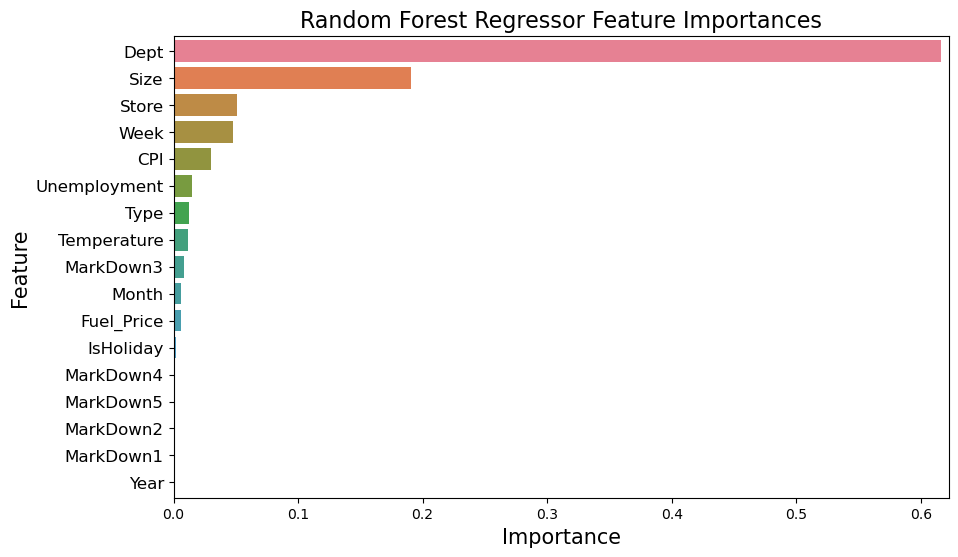

In [125]:
# Create hbar plot of all features and their individual importance scores
fig, ax = plt.subplots(figsize=(10, 6))
sns.color_palette("husl", 8)
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette="husl") #palette=palette
# ax.bar_label(ax.containers[0], padding=2)

ax.margins(y=0.01)
ax.margins(x=0.01)
plt.title("Random Forest Regressor Feature Importances", size = 16)
plt.xlabel("Importance", size = 15)
plt.xticks(rotation=0)
plt.ylabel("Feature", size = 15)
plt.yticks(rotation=0, size=12)
plt.show()

Top 10 Feature Importances:
- 'Dept'
- 'Size'
- 'Store'
- 'Week'
- 'CPI'
- 'Unemployment'
- 'Type'
- 'Temperature'
- 'MarkDown3'
- 'Month'

initial takeaways after extracting feature values:
- skeptical that markdown3 is important, as all the other markdowns are not even registering on the chart
- store related features make up the top 3, followed by week
- aligns with my earlier observations that the disributions of external factor features (e.g. gas prices, inflations) did not suggest they would hold predictive power in our forecasting
- date and holiday/promotional period features are much less important than expected
  - while I feel they are key, we will maintain our iterative approach and not include those not in the top 10 for next model


In [127]:
# Extract top 10 features to use in model
sorted_feat_importances = feat_importances_df.sort_values(by='Importance', ascending=False)
top_ten_list = sorted_feat_importances['Feature'].head(10).tolist()
top_ten_list

['Dept',
 'Size',
 'Store',
 'Week',
 'CPI',
 'Unemployment',
 'Type',
 'Temperature',
 'MarkDown3',
 'Month']

###  RandomForestRegressor w/ only the top ten features

In [128]:
# Create new X_date variable for next test
# Drop all markdown and external features
X_top_10_feat = train_df[top_ten_list]

# Split train df into X and val based on year
X_train_top_10 = X_top_10_feat.loc[(X_all['Year'] == 2010) | (X_all['Year'] == 2011)]
X_test_top_10 = X_top_10_feat.loc[(X_all['Year'] == 2012)]
y_train_top_10 = val_df.loc[(val_df.index == 2010) | (val_df.index == 2011)]
y_test_top_10 = val_df.loc[(val_df.index == 2012)]

In [129]:
# Assign training numeric columns to respective variables
num_to_min_max = X_top_10_feat.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
top_10_feat_pipeline = Pipeline([('mss', MinMaxScaler())])

In [130]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("top_10_feat_pipe", top_10_feat_pipeline, num_to_min_max)])
ct

ColumnTransformer(transformers=[('top_10_feat_pipe',
                                 Pipeline(steps=[('mss', MinMaxScaler())]),
                                 Index(['Dept', 'Size', 'Store', 'Week', 'CPI', 'Unemployment', 'Type',
       'Temperature', 'MarkDown3', 'Month'],
      dtype='object'))])

In [131]:
# build rfr pipepline with minmax scaled numeric values
rfr_top_10_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_top_10_pipe = Pipeline(rfr_top_10_steps)

rfr_top_10_pipe.fit(X_train_top_10, y_train_top_10)

# Predict using the pipeline 
rfr_top_10_y_pred = rfr_top_10_pipe.predict(X_test_top_10)

In [132]:
rfr_top_10_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('top_10_feat_pipe',
                                                  Pipeline(steps=[('mss',
                                                                   MinMaxScaler())]),
                                                  Index(['Dept', 'Size', 'Store', 'Week', 'CPI', 'Unemployment', 'Type',
       'Temperature', 'MarkDown3', 'Month'],
      dtype='object'))])),
                ('rfr', RandomForestRegressor(max_depth=20, random_state=42))])

In [133]:
# Define score variables and print score report
rmse_top_10 = MSE(y_test_top_10, rfr_top_10_y_pred, squared=False)
mae_top_10 = MAE(y_test_top_10, rfr_top_10_y_pred)

print('Scaled Date and Store Features Scores:')
print(f'RMSE: {rmse_top_10:.2f}')
print(f'MAE: {mae_top_10:.2f}')

Scaled Date and Store Features Scores:
RMSE: 5063.34
MAE: 2294.50


- using only the top ten features marginally improves our MAE
- the lack of meaningful change in our scores make sense given the importances of our bottom 5 features
  - their cumulative importance score is only 0.00381

###  RandomForestRegressor w/ only the top ten features

- While the feature_importance_ attribute is a valuable tool, we will manually select our features for now
- from our EDA and domain knowledge we feel the key to this problem are the date and store features
- we will test this by droping all non-date and external factors

In [136]:
# Create new X_date variable for next test
# Drop all markdown and external features
X_date_store_feat = train_df.drop(columns=['Date','Weekly_Sales','Temperature','Fuel_Price',
                                           'CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3',
                                           'MarkDown4','MarkDown5'], axis=1)

# Split train df into X and val based on year
X_train_date_store = X_date_store_feat.loc[(X_all['Year'] == 2010) | (X_all['Year'] == 2011)]
X_test_date_store = X_date_store_feat.loc[(X_all['Year'] == 2012)]
y_train_date_store = val_df.loc[(val_df.index == 2010) | (val_df.index == 2011)]
y_test_date_store = val_df.loc[(val_df.index == 2012)]

In [137]:
print(X_train_date_store.shape)
print(X_test_date_store.shape)
print(y_train_date_store.shape)
print(y_test_date_store.shape)

(294132, 8)
(127438, 8)
(294132, 1)
(127438, 1)


In [138]:
# Assign training numeric columns to respective variables
num_to_min_max = X_train_date_store.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
min_max_date_store_pipeline = Pipeline([('mss', MinMaxScaler())])

In [139]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("min_max_date_store_pipe", min_max_date_store_pipeline, num_to_min_max)])
ct

ColumnTransformer(transformers=[('min_max_date_store_pipe',
                                 Pipeline(steps=[('mss', MinMaxScaler())]),
                                 Index(['Store', 'Dept', 'Type', 'Size', 'IsHoliday', 'Year', 'Month', 'Week'], dtype='object'))])

In [140]:
# build rfr pipepline with minmax scaled numeric values
rfr_date_store_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_date_store_pipe = Pipeline(rfr_date_store_steps)

rfr_date_store_pipe.fit(X_train_date_store, y_train_date_store)

# Predict using the pipeline 
rfr_date_store_y_pred = rfr_date_store_pipe.predict(X_test_date_store)

In [142]:
# Define score variables and print score report
rmse_date_store = MSE(y_test_date_store, rfr_date_store_y_pred, squared=False)
mae_date_store = MAE(y_test_date_store, rfr_date_store_y_pred)

print('Scaled Date and Store Features Scores:')
print(f'RMSE: {rmse_date_store:.2f}')
print(f'MAE: {mae_date_store:.2f}')

Scaled Date and Store Features Scores:
RMSE: 3545.91
MAE: 1672.03


In [149]:
# calculate percentage drop in scores from previous iteration
rmse_drop = ((rmse_top_10 - rmse_date_store) / rmse_top_10) * 100
mae_drop = ((mae_top_10 - mae_date_store) / mae_top_10) * 100

# Print the percentage drops
print('Percentage drop (improvement) from previous model:')
print(f'RMSE: {rmse_drop:.2f}%')
print(f'MAE: {mae_drop:.2f}%')

Percentage drop (improvement) from previous model:
RMSE: 29.97%
MAE: 27.13%


In [148]:
rmse_drop

0.2996893656148914

Results have significantly improved as we expected
- RMSE fell by 29.97%
- MAE fell by 27.13%

It's looking like historical store sales data is our best predictor of future sales

#### Extract and visualize feature importances for all store categorical and date features

In [143]:
# rerun feature_importance workflow with our manually selected features
feat_importances = pd.DataFrame(zip(X_train_date_store.columns, rfr_date_store_pipe[1].feature_importances_)).sort_values(by = 1,
                                                                    ascending = False)

In [144]:
feat_importances.columns = ['Feature', 'Importance']
feat_importances

,Feature,Importance
1,Dept,0.616086
3,Size,0.216493
0,Store,0.072192
7,Week,0.063378
2,Type,0.012971
6,Month,0.011592
5,Year,0.004630
4,IsHoliday,0.002658


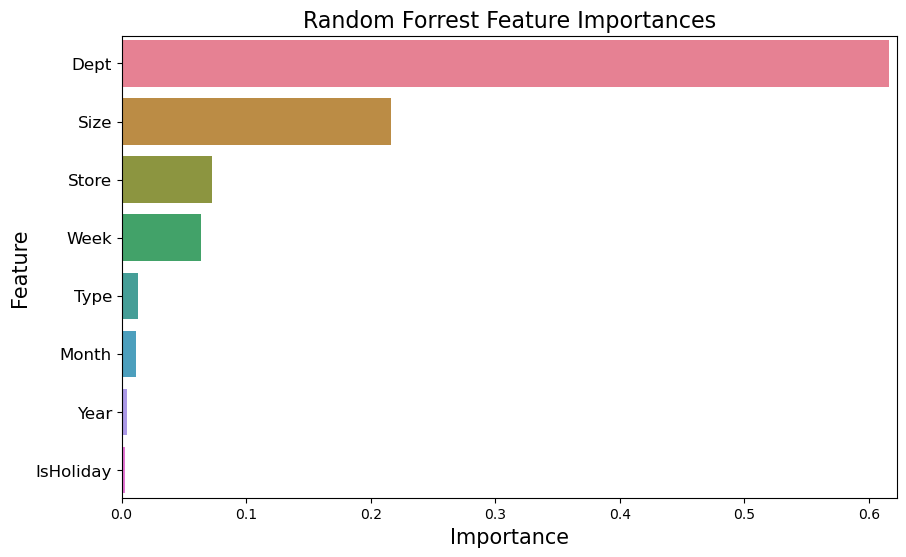

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.color_palette("husl", 8)
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances, palette="husl") #palette=palette
# ax.bar_label(ax.containers[0], padding=2)

ax.margins(y=0.01)
ax.margins(x=0.01)
plt.title("Random Forrest Feature Importances", size = 16)
plt.xlabel("Importance", size = 15)
plt.xticks(rotation=0)
plt.ylabel("Feature", size = 15)
plt.yticks(rotation=0, size=12)
plt.show()

###  RandomForestRegressor w/ only the top five features

- Despite the lack of value add last time we deployed this method, we should not assume that will be the case again
- having reduced the number of features, we'd be remiss to not check for any additional insight 
- best practices also dictate we continue our iterative approach and continuously test and evaluate our assumptions 

In [151]:
# Create new X_date variable for next test
# Drop all markdown and external features
X_top_date_store = train_df.drop(columns=['Date','Weekly_Sales','Temperature','Fuel_Price',
                                           'CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3',
                                           'MarkDown4','MarkDown5', 'IsHoliday', 'Year', 'Month'], axis=1)

# Split train df into X and val based on year
X_train_top_5 = X_top_date_store.loc[(X_all['Year'] == 2010) | (X_all['Year'] == 2011)]
X_test_top_5 = X_top_date_store.loc[(X_all['Year'] == 2012)]
y_train_top_5 = val_df.loc[(val_df.index == 2010) | (val_df.index == 2011)]
y_test_top_5 = val_df.loc[(val_df.index == 2012)]

In [152]:
# Assign training numeric columns to respective variables
num_to_min_max = X_top_date_store.select_dtypes(['int', 'float']).columns

# Establish pipelines for each feature type
min_max_date_store_pipeline = Pipeline([('mss', MinMaxScaler())])

In [153]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
                       [("min_max_date_store_pipe", min_max_date_store_pipeline, num_to_min_max)])
ct

ColumnTransformer(transformers=[('min_max_date_store_pipe',
                                 Pipeline(steps=[('mss', MinMaxScaler())]),
                                 Index(['Store', 'Dept', 'Type', 'Size', 'Week'], dtype='object'))])

In [154]:
# build rfr pipepline with minmax scaled numeric values
rfr_top_5_steps = [('preprocess', ct), 
             ('rfr', RandomForestRegressor(max_depth=20, random_state = 42))]

rfr_top_5_pipe = Pipeline(rfr_top_5_steps)

rfr_top_5_pipe.fit(X_train_top_5, y_train_top_5)

# Predict using the pipeline 
rfr_top_5_y_pred = rfr_top_5_pipe.predict(X_test_top_5)

In [155]:
rmse_top_5_store = MSE(y_test_top_5, rfr_top_5_y_pred, squared=False)
mae_top_5_store = MAE(y_test_top_5, rfr_top_5_y_pred)

print('Scaled Date and Store Features Scores:')
print(f'RMSE: {rmse_top_5_store:.2f}')
print(f'MAE: {mae_top_5_store:.2f}')

Scaled Date and Store Features Scores:
RMSE: 3827.15
MAE: 1854.40


Including only our new top 5 features led to worse performance

- the bottom 3 features we excluded have a cumulative importance of less than 0.02
  - Month: 0.011592
  - Year: 0.004630
  - IsHoliday: 0.002658
- despite their supposed lack of importance, the model scoring result shows otherwise
- this result did not surprise us, since we inferred those features to be key since we conducted our EDA
    

## Conclusions

1. Even with incomplete historical sales data, we can cheaply and reliably forecast future sales

2. This tool can provide material benefit for Marketplace sellers
- Could become a significant differentiator re Walmart Marketplace's ability to compete with the likes of Amazon

3. We believe equipping sellers with our forecasting tool can only improve the marketplace experience 
- sellers being able to optimize planning and respond to market trends allows for a more seamless customer experience
- the value of the tool to sellers lures more sellers to marketplace giving customers access to a broader range of goods and solidifies Walmart's positioning as the one stop shop

4. The benefits of this tool could trickle down throughout the Walmart ecosystem
- the better the marketplace is able to meet our customers' needs, the more time they will spend on walmart.com
- we expect increased time and spend on our platforms to be a catalyst for improved sale conversion as it creates additional opportunities for activities such as cross sales
- the additional data derived from the incease in marketplace activity will allow for the continous improvement and spearheading of tools such as this one

## Future Work

### Save this for the prophet model, which can take a custom holiday argument

In [ ]:
# get list of US holidays from the holidays python package for the applicable years (2010,2011,2012)
for date, name in sorted(holidays.US(years=[2010,2011,2012]).items()):
    print(date, name)